In [3]:
import Pkg

#Pkg.add("CSV")
#Pkg.add("Random")

using Zygote
using Flux
using Flux: onehotbatch, onecold, crossentropy
using MLDatasets
#using CUDA
using Statistics
using Plots
using Images
using Colors
using ImageTransformations
using MLUtils
using CSV
using Random
using DataFrames


In [4]:
# the individual classes where each image is 32x32 pixels

class_names = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck"
];

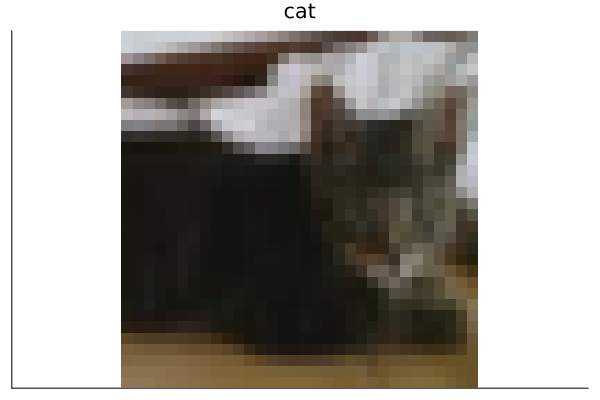

In [59]:
# Loading the CIFAR-10 dataset

train_x_true, train_y_true = CIFAR10(:train)[:];

# picking some image to examine (change this to pick a new image)
upp_choice = 10

# Select the first image (H, W, C) = (32, 32, 3)
image_data = Float64.(train_x_true[:, :, :, upp_choice])   # Normalize first

rotated_image = reverse(permutedims(image_data, (2, 1, 3)), dims=2)

# Display image correctly (RGB expects (3, H, W))
plot(colorview(RGB, permutedims(rotated_image, (3, 1, 2))))
plot!(title=(class_names[train_y_true[upp_choice] + 1]))
plot!(xticks = false, yticks = false)

In [6]:
# pulling all data from CIFAR-10

train_x, train_y = CIFAR10(:train).features, CIFAR10(:train).targets
test_x, test_y = CIFAR10(:test).features, CIFAR10(:test).targets

# ordering it correctly for Flux

train_x = permutedims(Float32.(train_x) , (1,2,3,4))  
test_x = permutedims(Float32.(test_x) , (1,2,3,4)) 

# hot encoding the labels

train_y = onehotbatch(vec(train_y), 0:9)  
test_y = onehotbatch(vec(test_y), 0:9)

;

In [165]:
# weights are learned
# biases are learned

# Convolutional Neural Network

# Layer 1 -> takes 3 channels correpsoding to RGB and spits out 16 channels followed by MaxPool
conv1 = Conv((3,3), 3=>16, relu, pad=1)
pool1 = MaxPool((2,2))

# Layer 2 -> takes 16 channels and spits out 32 channels followed by MaxPool
conv2 = Conv((3,3), 16=>32, relu, pad=1)
pool2 = MaxPool((2,2))

# Layer 3 -> takes 32 channels and spits out 64 channels followed by MaxPool
conv3 = Conv((3,3), 32=>64, relu, pad=1)
pool3 = MaxPool((2,2))

# Layer 4 -> takes 64 channels and spits out 128 channels followed by MaxPool
conv4 = Conv((3,3), 64=>128, relu, pad=1)
pool4 = MaxPool((2,2))

# flattens the data for use in the dense layers
flatten = Flux.flatten

# Dense layers corresponding to a normal neural network
dense1 = Dense(512, 32, relu)
dense3 = Dense(32, 10)

# softmax layer for classification
model = Chain(
    conv1,
    pool1,
    BatchNorm(16),
    conv2,
    pool2,
    BatchNorm(32),
    conv3,
    pool3,
    BatchNorm(64),
    conv4,
    pool4,
    BatchNorm(128),
    flatten,
    dense1,
    dense3,
    softmax
)

Chain(
  Conv((3, 3), 3 => 16, relu, pad=1),   # 448 parameters
  MaxPool((2, 2)),
  BatchNorm(16),                        # 32 parameters, plus 32
  Conv((3, 3), 16 => 32, relu, pad=1),  # 4_640 parameters
  MaxPool((2, 2)),
  BatchNorm(32),                        # 64 parameters, plus 64
  Conv((3, 3), 32 => 64, relu, pad=1),  # 18_496 parameters
  MaxPool((2, 2)),
  BatchNorm(64),                        # 128 parameters, plus 128
  Conv((3, 3), 64 => 128, relu, pad=1),  # 73_856 parameters
  MaxPool((2, 2)),
  BatchNorm(128),                       # 256 parameters, plus 256
  Flux.flatten,
  Dense(512 => 32, relu),               # 16_416 parameters
  Dense(32 => 10),                      # 330 parameters
  NNlib.softmax,
)         # Total: 20 trainable arrays, 114_666 parameters,
          # plus 8 non-trainable, 480 parameters, summarysize 451.867 KiB.

In [166]:
# Using the crossentropy loss function
loss(m, x, y) = crossentropy(m(x), y)

# Using the ADAM optimizer
opt = ADAM();

In [167]:
# Please don't ask me questions here. This gave me so many issues

# function to train the model. Takes in the model, training data, optimizer, number of epochs, and batch size
function train_model!(model, train_X, train_Y, opt, epochs, batch_size)

    # this is the data loader that will be used to load the data in batches
    data_loader = Flux.DataLoader((train_X, train_Y), batchsize=batch_size, shuffle=true)
    
    # setting up the optimizer and list ot gather the loss
    opt_state = Flux.setup(opt, model)  
    total_loss = []

    # training the model through all epochs
    for epoch in 1:epochs
        epoch_loss = 0
        
        # going through each batch
        for (x, y) in data_loader
            # calculating the gradient and updating the weights
            gs = Flux.gradient(model -> Flux.Losses.crossentropy(model(x), y), model)[1]  
            Flux.update!(opt_state, Flux.trainable(model), gs)

            # updating the epoch loss for plotting later
            epoch_loss += Flux.Losses.crossentropy(model(x), y)
        end

        println("Epoch $epoch complete")
        push!(total_loss, epoch_loss)

    end
    return total_loss

end;

In [170]:
epochs = 15
batch_size = 64;

In [171]:
loss_list = train_model!(model, train_x, train_y, opt, epochs, batch_size);

Epoch 1 complete
Epoch 2 complete
Epoch 3 complete
Epoch 4 complete
Epoch 5 complete
Epoch 6 complete
Epoch 7 complete
Epoch 8 complete
Epoch 9 complete
Epoch 10 complete
Epoch 11 complete
Epoch 12 complete
Epoch 13 complete
Epoch 14 complete
Epoch 15 complete


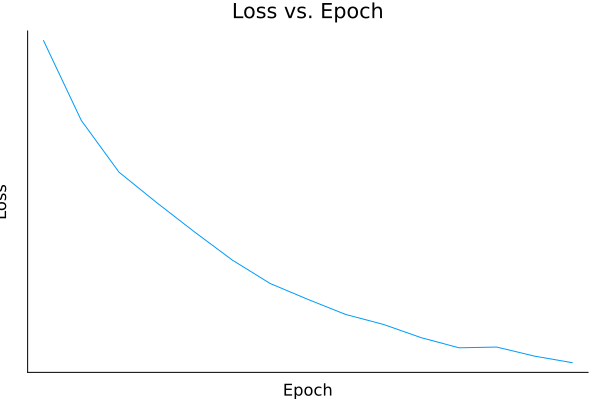

In [172]:
p1 = plot(1:epochs, loss_list, xlabel="Epoch", ylabel="Loss", title="Loss vs. Epoch", legend=false, xticks=false, yticks=false)
display(p1)

In [195]:
#visualize_layers(model, train_x[:, :, :, 1:1])

accuracy(x, y) = mean(onecold(model(x)) .== onecold(y))
println("Test Accuracy: ", accuracy(test_x, test_y))


Test Accuracy: 0.7285


In [173]:
function visualize_layer(input_data, layer, filter_labels)
       output = layer(input_data)  # Apply the convolutional layer
       num_filters = size(output, 4)  # Number of output channels
       label = filter_labels[1]
       
       # Rotate the input image 90 degrees to the right
       rotated_input = reverse(permutedims(input_data[:, :, 1, 1], (2, 1)), dims=1)
       
       # Create input plot
       input_plot = heatmap(rotated_input, axis=nothing, title="", xticks=false, yticks=false, colorbar=false,
           aspect_ratio=:equal
       )
       
       # Create output plots for each filter response with labels
       output_plots = [
           heatmap(
               reverse(permutedims(output[:, :, 1, i], (2, 1)), dims=1),  # Rotate each output image
               axis=nothing, 
               title=filter_labels,
               xticks=false, yticks=false, colorbar=false
           ) 
           for i in 1:num_filters
       ]
       
       # Arrange plots in a grid (side by side)
       plot(input_plot, output_plots..., layout=(1, num_filters + 1))
end


# Define each filter as a matrix

# Laplacian
f1 = [ 0  -1  0; 
       -1  4 -1;  
       0  -1  0 ]

# Sharpening
f2 = [ 0  -1  0; 
       -1  9 -1;  
       0  -1  0 ]

# Sobels vertical and horizontal
f3 = [ 1   2  1;  
       0  0  0; 
       -1  -2 -1 ]

f4 = [ 1   0  -1;  
       2   0  -2;  
       1   0  -1 ]

# Gaussian Blur
f5 = (1/16).*[ 1   2  1;  
               2  4  2;  
               1   2  1 ]

f7 = (1/273).*[ 1  4  7  4 1; 
                4 16 26 16 4; 
                7 26 41 26 7; 
                4 16 26 16 4; 
                1  4  7  4 1 ] 

f8 = (1/1003) .* [ 0   0  1   2  1  0  0; 
                   0   3 13  22 13  3  0; 
                   1  13 59  97 59 13  1; 
                   2  22 97 159 97 22  2; 
                   1  13 59  97 59 13  1; 
                   0   3 13  22 13  3  0; 
                   0   0  1   2  1  0  0 ]

# Embossing
f6 = [-2  -1  0; 
      -1   1  1;  
       0   1  2 ]

# Box Blur
f9 = (1/9) .* [ 1 1 1; 
                1 1 1; 
                1 1 1 ]


# Unsharp Masking
f10 = (-1/256).*[ 1  4    6  4  1; 
                  4 16   24 16  4; 
                  6 24 -476 24  6; 
                  4 16   24 16  4; 
                  1  4    6  4  1 ]

# some custom filter
f11 = [ 1 0 1 0 1; 
        0 0 0 0 0; 
        1 0 5 0 1; 
        0 0 0 0 0; 
        1 0 1 0 1]

# Inverse Gaussian Blur
f12 = (1/14).*[ 20  5 20; 
                 5  0  5; 
                20  5 20]

# Alternative Sobels
f13 = [ 3  0  -3; 
       10  0 -10; 
        3  0  -3]

f14 = [  3  10  3; 
         0   0  0; 
        -3 -10 -3]

# Scharr Operators
f15 = [ 47  0  -47; 
       162  0 -162; 
        47  0  -47]

f17 = [ 47  162  47; 
         0    0   0; 
       -47 -162 -47]

# Alternatice Laplacian
f18 = [ -1  2 -1; 
         2 -4  2; 
        -1  2 -1]

# Nine point laplacian which is the only optimal 3x3 laplacian alternative
f19 = (1/6) .* [ 1   4  1; 
                 4 -20  4; 
                 1   4  1]

# Reshape each filter to include the input channel and output channel dimensions (3, 3, 1, 1)
f1_tensor = reshape(f1, (3, 3, 1, 1))
f2_tensor = reshape(f2, (3, 3, 1, 1))
f3_tensor = reshape(f3, (3, 3, 1, 1))
f4_tensor = reshape(f4, (3, 3, 1, 1))
f5_tensor = reshape(f5, (3, 3, 1, 1))
f6_tensor = reshape(f6, (3, 3, 1, 1))
f7_tensor = reshape(f7, (5, 5, 1, 1))
f8_tensor = reshape(f8, (7, 7, 1, 1))
f9_tensor = reshape(f9, (3, 3, 1, 1))
f10_tensor = reshape(f10, (5, 5, 1, 1))
f11_tensor = reshape(f11, (5, 5, 1, 1))
f12_tensor = reshape(f12, (3, 3, 1, 1))
f13_tensor = reshape(f13, (3, 3, 1, 1))
f14_tensor = reshape(f14, (3, 3, 1, 1))
f15_tensor = reshape(f15, (3, 3, 1, 1))
f17_tensor = reshape(f17, (3, 3, 1, 1))
f18_tensor = reshape(f18, (3, 3, 1, 1))
f19_tensor = reshape(f19, (3, 3, 1, 1))


# Define filter labels corresponding to their function
filter_labels = [
    "Laplacian (Edge Detection)", 
    "Sharpening", 
    "Sobel (Vertical Edges)", 
    "Sobel (Horizontal Edges)", 
    "Gaussian Blur",
    "Embossing",
    "Large Gaussian Blur",
    "Super Large Gaussian Blur",
    "Box Blur",
    "Unsharp Masking",
    "Some Custom Filter",
    "Inverse Gaussian Blur",
    "Alternative Sobel (Vertical Edges)",
    "Alternative Sobel (Horizontal Edges)",
    "Scharr Operator (Vertical Edges)",
    "Empty",
    "Scharr Operator (Horizontal Edges)",
    "Alternative Laplacian",
    "Nine-point Laplacian"
];

n = length(filter_labels)

;

In [174]:
# introduce types of padding and stride

pad_set = 1
stride_set = 1
choice = 171
;

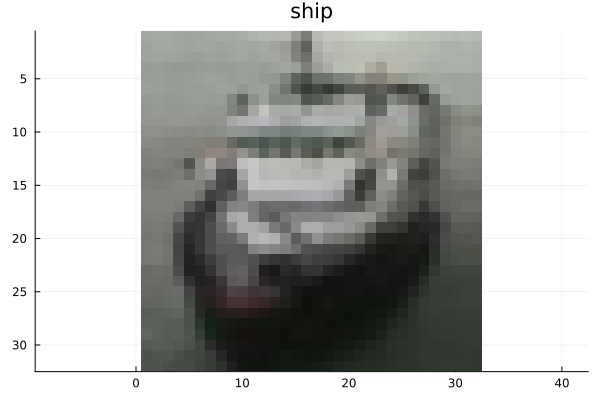

In [175]:
input_data = train_x[:, :, :, choice:choice];

image_data = Float64.(train_x_true[:, :, :, choice])   # Normalize first

rotated_image = reverse(permutedims(image_data, (2, 1, 3)), dims=2)

plot(colorview(RGB, permutedims(rotated_image, (3, 1, 2))))
image_label = class_names[train_y_true[choice] + 1]
plot!(title=image_label)

In [176]:
conv_layer_1 = Conv((3, 3), 3 => n, pad=pad_set, stride = stride_set)
conv_layer_1.weight .=f1_tensor

conv_layer_2 = Conv((3, 3), 3 => n, pad=pad_set, stride = stride_set)
conv_layer_2.weight .=f2_tensor

conv_layer_3 = Conv((3, 3), 3 => n, pad=pad_set, stride = stride_set)
conv_layer_3.weight .=f3_tensor

conv_layer_4 = Conv((3, 3), 3 => n, pad=pad_set, stride = stride_set)
conv_layer_4.weight .=f4_tensor

conv_layer_5 = Conv((3, 3), 3 => n, pad=pad_set, stride = stride_set)
conv_layer_5.weight .=f5_tensor

conv_layer_6 = Conv((3, 3), 3 => n, pad=pad_set, stride = stride_set)
conv_layer_6.weight .=f6_tensor;

conv_layer_7 = Conv((5,5), 3 => n, pad=pad_set, stride = stride_set)
conv_layer_7.weight .=f7_tensor;

conv_layer_8 = Conv((7,7), 3 => n, pad=pad_set, stride = stride_set)
conv_layer_8.weight .=f8_tensor;

conv_layer_9 = Conv((3,3), 3 => n, pad=pad_set, stride = stride_set)
conv_layer_9.weight .=f9_tensor;

conv_layer_10 = Conv((5,5), 3 => n, pad=pad_set, stride = stride_set)
conv_layer_10.weight .=f10_tensor;

conv_layer_11 = Conv((5,5), 3 => n, pad=pad_set, stride = stride_set)
conv_layer_11.weight .=f11_tensor;

conv_layer_12 = Conv((3,3), 3 => n, pad=pad_set, stride = stride_set)
conv_layer_12.weight .=f12_tensor;

conv_layer_13 = Conv((3,3), 3 => n, pad=pad_set, stride = stride_set)
conv_layer_13.weight .=f13_tensor;

conv_layer_14 = Conv((3,3), 3 => n, pad=pad_set, stride = stride_set)
conv_layer_14.weight .=f14_tensor;

conv_layer_15 = Conv((3,3), 3 => n, pad=pad_set, stride = stride_set)
conv_layer_15.weight .=f15_tensor;

conv_layer_17 = Conv((3,3), 3 => n, pad=pad_set, stride = stride_set)
conv_layer_17.weight .=f17_tensor;

conv_layer_18 = Conv((3,3), 3 => n, pad=pad_set, stride = stride_set)
conv_layer_18.weight .=f18_tensor;

conv_layer_19 = Conv((3,3), 3 => n, pad=pad_set, stride = stride_set)
conv_layer_19.weight .=f19_tensor;

;

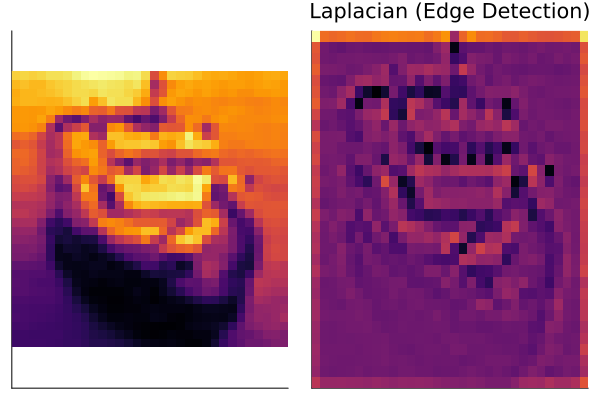

In [177]:
visualize_layer(input_data, conv_layer_1, filter_labels[1])

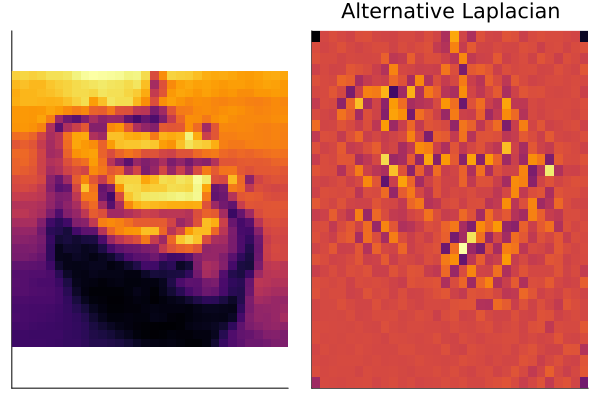

In [178]:
visualize_layer(input_data, conv_layer_18, filter_labels[18])

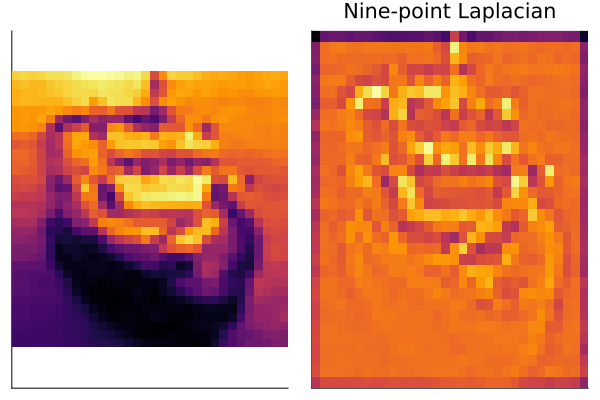

In [179]:
visualize_layer(input_data, conv_layer_19, filter_labels[19])

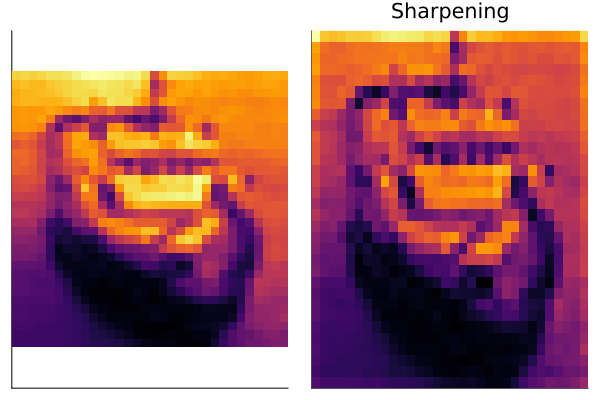

In [180]:
visualize_layer(input_data, conv_layer_2, filter_labels[2])

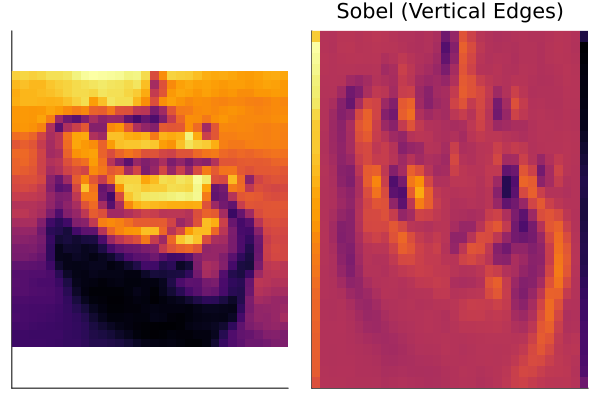

In [181]:
visualize_layer(input_data, conv_layer_3, filter_labels[3])

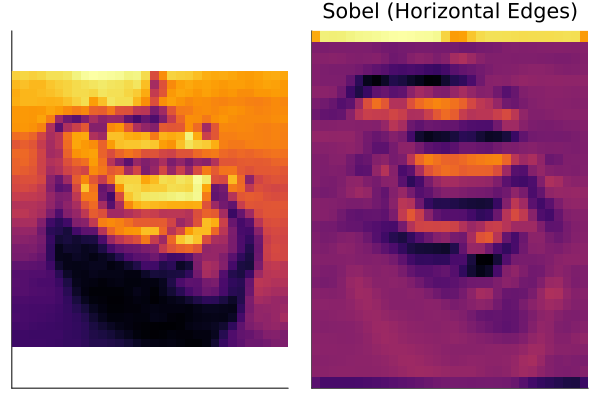

In [182]:
visualize_layer(input_data, conv_layer_4, filter_labels[4])

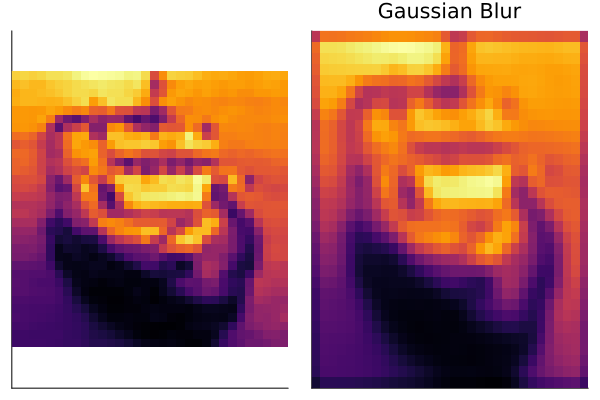

In [183]:
visualize_layer(input_data, conv_layer_5, filter_labels[5])

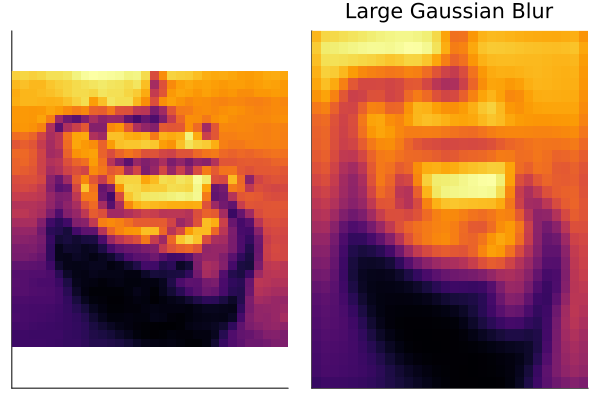

In [184]:
visualize_layer(input_data, conv_layer_7, filter_labels[7])

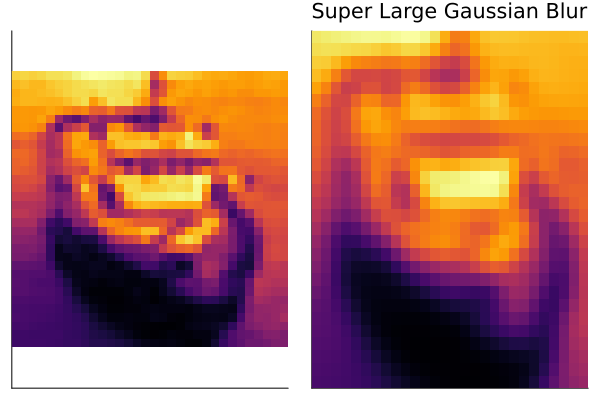

In [185]:
visualize_layer(input_data, conv_layer_8, filter_labels[8])

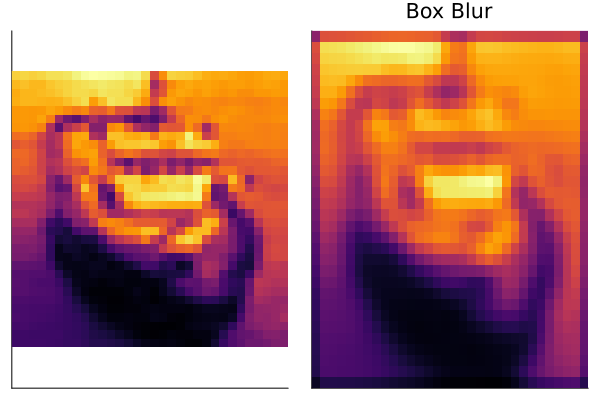

In [186]:
visualize_layer(input_data, conv_layer_9, filter_labels[9])

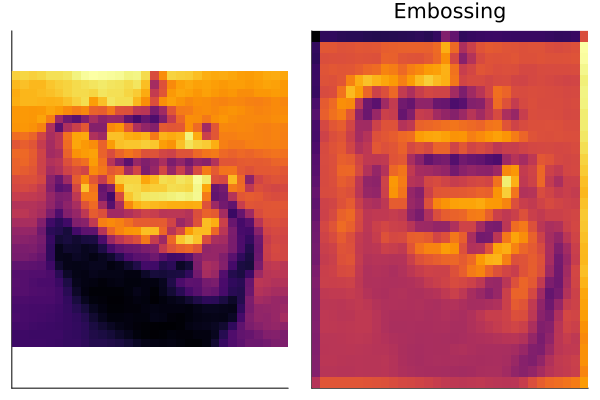

In [187]:
visualize_layer(input_data, conv_layer_6, filter_labels[6])

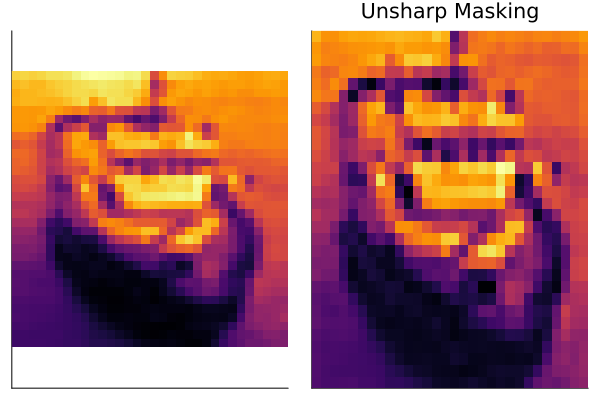

In [188]:
visualize_layer(input_data, conv_layer_10, filter_labels[10])

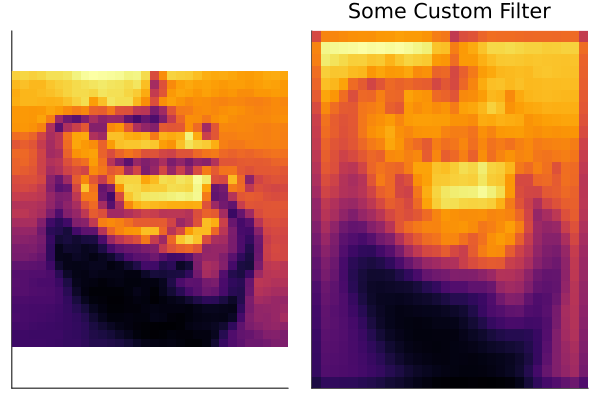

In [189]:
visualize_layer(input_data, conv_layer_11, filter_labels[11])

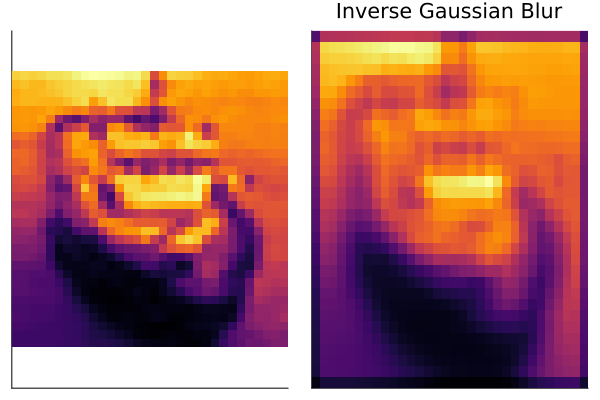

In [190]:
visualize_layer(input_data, conv_layer_12, filter_labels[12])

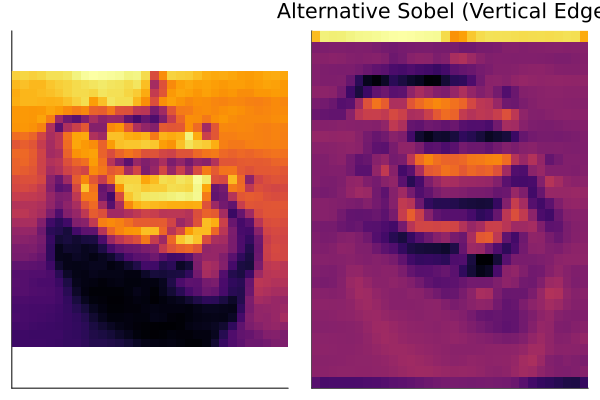

In [191]:
visualize_layer(input_data, conv_layer_13, filter_labels[13])

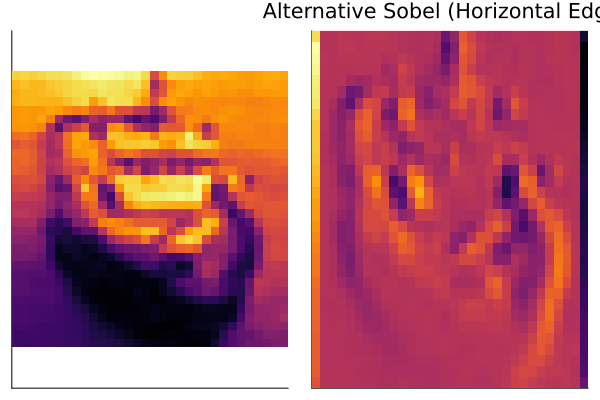

In [192]:
visualize_layer(input_data, conv_layer_14, filter_labels[14])

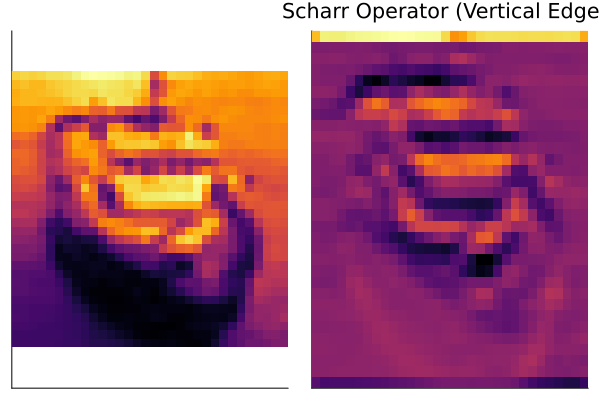

In [193]:
visualize_layer(input_data, conv_layer_15, filter_labels[15])

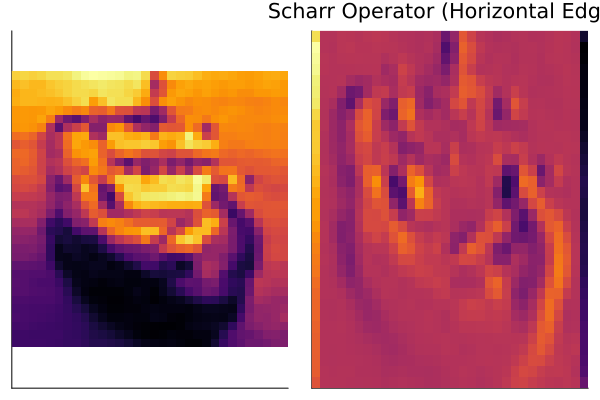

In [194]:
visualize_layer(input_data, conv_layer_17, filter_labels[17])